In [3]:
import fastf1
import pandas as pd
import numpy as np
import seaborn as sns
from fastf1.plotting import setup_mpl
import matplotlib.pyplot as plt

setup_mpl(color_scheme='fastf1', misc_mpl_mods=False)  # Use FastF1's default styling

In [4]:
# Load the 2023 Monaco GP Race Session
session = fastf1.get_session(2023, 'Monaco', 'R')
session.load()

req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) C:\Users\DELL\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track s

In [6]:
# Get all laps for Max Verstappen
laps = session.laps.pick_drivers("VER").copy()

# Convert Time to seconds for easier calculations
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# Display first few rows
laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
0,0 days 01:03:27.458000,VER,1,0 days 00:01:24.238000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:37.420000,...,Red Bull Racing,0 days 01:02:02.950000,2023-05-28 13:03:03.927,12,1.0,False,,False,False,84.238
1,0 days 01:04:46.825000,VER,1,0 days 00:01:19.367000,2.0,1.0,NaT,NaT,0 days 00:00:20.954000,0 days 00:00:37.366000,...,Red Bull Racing,0 days 01:03:27.458000,2023-05-28 13:04:28.435,1,1.0,False,,False,True,79.367
2,0 days 01:06:05.899000,VER,1,0 days 00:01:19.074000,3.0,1.0,NaT,NaT,0 days 00:00:20.854000,0 days 00:00:37.288000,...,Red Bull Racing,0 days 01:04:46.825000,2023-05-28 13:05:47.802,1,1.0,False,,False,True,79.074
3,0 days 01:07:24.028000,VER,1,0 days 00:01:18.129000,4.0,1.0,NaT,NaT,0 days 00:00:20.835000,0 days 00:00:36.637000,...,Red Bull Racing,0 days 01:06:05.899000,2023-05-28 13:07:06.876,1,1.0,False,,False,True,78.129
4,0 days 01:08:42.047000,VER,1,0 days 00:01:18.019000,5.0,1.0,NaT,NaT,0 days 00:00:20.745000,0 days 00:00:36.734000,...,Red Bull Racing,0 days 01:07:24.028000,2023-05-28 13:08:25.005,1,1.0,False,,False,True,78.019


In [7]:
# Identify laps where a pit stop occurred
verstappen_pitstops = laps[laps['PitOutTime'].notna()]

# Select only relevant columns
verstappen_pitstops = verstappen_pitstops[['LapNumber', 'PitInTime', 'PitOutTime']]
verstappen_pitstops

,LapNumber,PitInTime,PitOutTime
55,56.0,NaT,0 days 02:14:41.935000


In [8]:
# Function to get car gaps at a given lap
def get_gaps(lap_number):
    lap_data = session.laps[session.laps['LapNumber'] == lap_number]
    
    # Get Verstappen's lap
    verstappen_lap = lap_data[lap_data['Driver'] == "VER"]
    if verstappen_lap.empty:
        return None, None  # Return None if lap not found
    
    verstappen_time = verstappen_lap['Time'].values[0]
    
    # Get closest car ahead
    cars_ahead = lap_data[lap_data['Time'] < verstappen_time].sort_values(by='Time', ascending=False)
    gap_ahead = (verstappen_time - cars_ahead['Time'].iloc[0]).total_seconds() if not cars_ahead.empty else None
    
    # Get closest car behind
    cars_behind = lap_data[lap_data['Time'] > verstappen_time].sort_values(by='Time', ascending=True)
    gap_behind = (cars_behind['Time'].iloc[0] - verstappen_time).total_seconds() if not cars_behind.empty else None
    
    return gap_ahead, gap_behind

# Compute gaps before and after each pit stop
gap_data = []

for _, pitstop in verstappen_pitstops.iterrows():
    lap_before = pitstop['LapNumber'] - 1
    lap_after = pitstop['LapNumber'] + 1
    
    gap_before = get_gaps(lap_before)
    gap_after = get_gaps(lap_after)
    
    gap_data.append({
        "LapNumber": pitstop['LapNumber'],
        "GapAheadBefore": gap_before[0],
        "GapBehindBefore": gap_before[1],
        "GapAheadAfter": gap_after[0],
        "GapBehindAfter": gap_after[1]
    })

# Convert to DataFrame
gap_df = pd.DataFrame(gap_data)
gap_df

,LapNumber,GapAheadBefore,GapBehindBefore,GapAheadAfter,GapBehindAfter
0,56.0,None,20.741,None,22.258


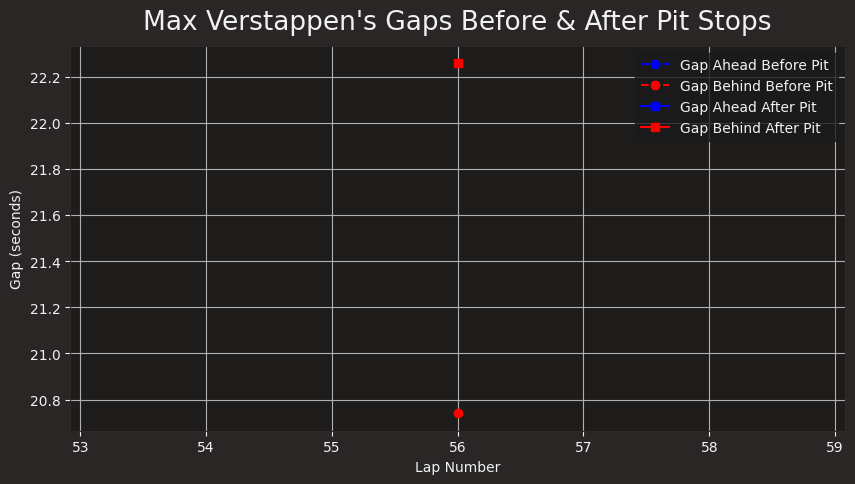

In [9]:
# Set up the plot
plt.figure(figsize=(10, 5))
plt.plot(gap_df['LapNumber'], gap_df['GapAheadBefore'], label="Gap Ahead Before Pit", marker='o', linestyle='--', color='blue')
plt.plot(gap_df['LapNumber'], gap_df['GapBehindBefore'], label="Gap Behind Before Pit", marker='o', linestyle='--', color='red')
plt.plot(gap_df['LapNumber'], gap_df['GapAheadAfter'], label="Gap Ahead After Pit", marker='s', linestyle='-', color='blue')
plt.plot(gap_df['LapNumber'], gap_df['GapBehindAfter'], label="Gap Behind After Pit", marker='s', linestyle='-', color='red')

# Labels and Legend
plt.xlabel("Lap Number")
plt.ylabel("Gap (seconds)")
plt.title("Max Verstappen's Gaps Before & After Pit Stops")
plt.legend()
plt.grid()
plt.show()